In [67]:
  ! pip install lifelines scikit-survival survshap shap jinja2 survinsights seaborn numba numpy==1.23.5 


  Using cached survinsights-0.0.3-py3-none-any.whl.metadata (1.9 kB)
  Using cached numpy-1.23.5.tar.gz (10.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "/usr/local/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/usr/local/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/usr/local/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 137, in get_requires_for_build_wheel
          backend = _build_backend()
        

In [68]:
pip install scikit-learn shap

Note: you may need to restart the kernel to use updated packages.


In [69]:
pip install scikit-survival

Note: you may need to restart the kernel to use updated packages.


In [70]:
pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install survshap

Note: you may need to restart the kernel to use updated packages.


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored

from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import fonctions_SurvTreeShap as fstp

from survshap import SurvivalModelExplainer, PredictSurvSHAP

In [95]:
import importlib
importlib.reload(fonctions_SurvTreeShap)

<module 'fonctions_SurvTreeShap' from '/home/onyxia/work/fonctions_SurvTreeShap.py'>

In [134]:
# Fixer une graine pour la reproductibilité
np.random.seed(42)

# Définir le nombre d'observations
n = 1000

# Simuler 10 variables explicatives (covariables) aléatoires
# Pour l'exemple, nous générons des variables de types continus et catégoriques
X = pd.DataFrame({
    'age': np.random.normal(50, 10, size=n),        # Age (moyenne 50, écart-type 10)
    'sex': np.random.choice([0, 1], size=n),         # Sexe (0 = féminin, 1 = masculin)
    'smoking': np.random.choice([0, 1], size=n),     # Tabagisme (0 = non, 1 = oui)
    'cholesterol': np.random.normal(200, 50, size=n), # Cholestérol
    'blood_pressure': np.random.normal(120, 15, size=n), # Pression sanguine
    'diabetes': np.random.choice([0, 1], size=n),    # Diabète (0 = non, 1 = oui)
    'exercise': np.random.choice([0, 1], size=n),    # Exercice (0 = non, 1 = oui)
    'alcohol': np.random.choice([0, 1], size=n),     # Alcool (0 = non, 1 = oui)
    'weight': np.random.normal(70, 10, size=n),      # Poids
    'height': np.random.normal(170, 10, size=n)      # Taille
})

# Coefficients associés à chaque covariable
beta = np.array([-0.05, 0.3, 0.5, 0.02, -0.01, 0.4, -0.2, 0.1, -0.02, 0.01])

# Temps de survie simulé à partir d'une loi exponentielle
linear_pred = np.dot(X, beta)
baseline_hazard = 0.01
survival_time = -np.log(np.random.uniform(size=n)) / (baseline_hazard * np.exp(linear_pred))

# Censure aléatoire (à 80% de probabilité de censure après un temps limite)
censoring_time = np.random.uniform(0, 100, size=n)
event_observed = survival_time <= censoring_time
observed_time = np.minimum(survival_time, censoring_time)

# Format compatible avec scikit-survival
y = Surv.from_arrays(event_observed, observed_time)

# Aperçu
print(X.head())
print(y[:5])

y_df = pd.DataFrame({
    "event": event_observed.astype(int),
    "time": observed_time
})

         age  sex  smoking  cholesterol  blood_pressure  diabetes  exercise  \
0  54.967142    0        0   184.539546      108.450059         1         1   
1  48.617357    1        0   162.392180      100.558250         0         0   
2  56.476885    0        0   215.958726      113.158188         1         0   
3  65.230299    1        0   267.022522      122.721399         0         0   
4  47.658466    0        1   106.241377      128.925442         0         1   

   alcohol     weight      height  
0        0  60.605368  178.511241  
1        1  81.192449  182.238559  
2        1  67.055442  173.379556  
3        0  84.527555  164.077592  
4        1  85.287479  179.757134  
[( True, 43.80126603) (False, 50.37734437) ( True,  2.37007815)
 ( True, 25.06271777) (False,  5.57355265)]


In [135]:
y_df.head()

,event,time
0,1,43.801266
1,0,50.377344
2,1,2.370078
3,1,25.062718
4,0,5.573553


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df, test_size=0.2, random_state=42)

In [137]:
y_train_RSF = Surv.from_dataframe("event", "time", y_train)
y_test_RSF = Surv.from_dataframe("event", "time", y_test)

In [138]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=3)
rsf.fit(X_train, y_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

In [139]:
times = np.arange(2, 96)
survs = rsf.predict_survival_function(X_test)



In [140]:
preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(y_train_RSF, y_test_RSF, preds, times)
print(score)

0.1789074563107175


In [141]:
y_pred_rsf = rsf.predict(X_test)
c_index = concordance_index_censored(y_test_RSF["event"], y_test_RSF["time"], y_pred_rsf)[0]
c_index


np.float64(0.7264335287379556)

In [142]:
! pip install numba scikit-learn

In [143]:
dir(fstp)

['STP_graph',
 'Shapvalues',
 'Shapvaluesrank',
 'SurvTreeSHAPexplainer',
 'Tree',
 'TreeExplainer',
 'VariableRank',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'compute_expectations',
 'extend_path',
 'np',
 'numba',
 'pd',
 'plt',
 'tqdm',
 'train_test_split',
 'tree_shap_recursive',
 'unwind_path',
 'unwound_path_sum']

In [148]:
STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)

100%|██████████| 800/800 [00:02<00:00, 272.45it/s]


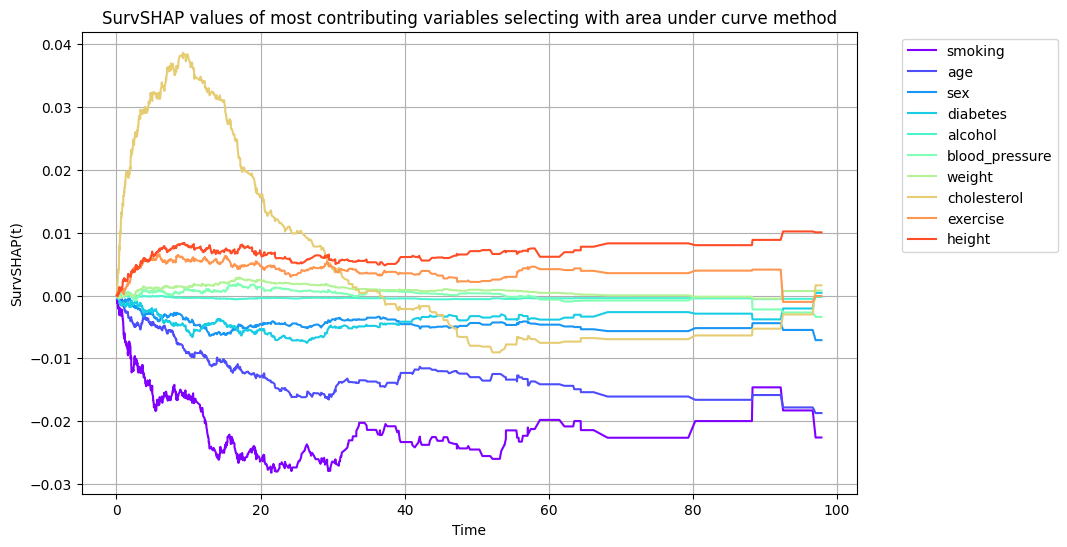

In [149]:
STS.plotgraph(0, "area", 0, 10)


100%|██████████| 800/800 [00:01<00:00, 403.05it/s]
/home/onyxia/work/fonctions_SurvTreeShap.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


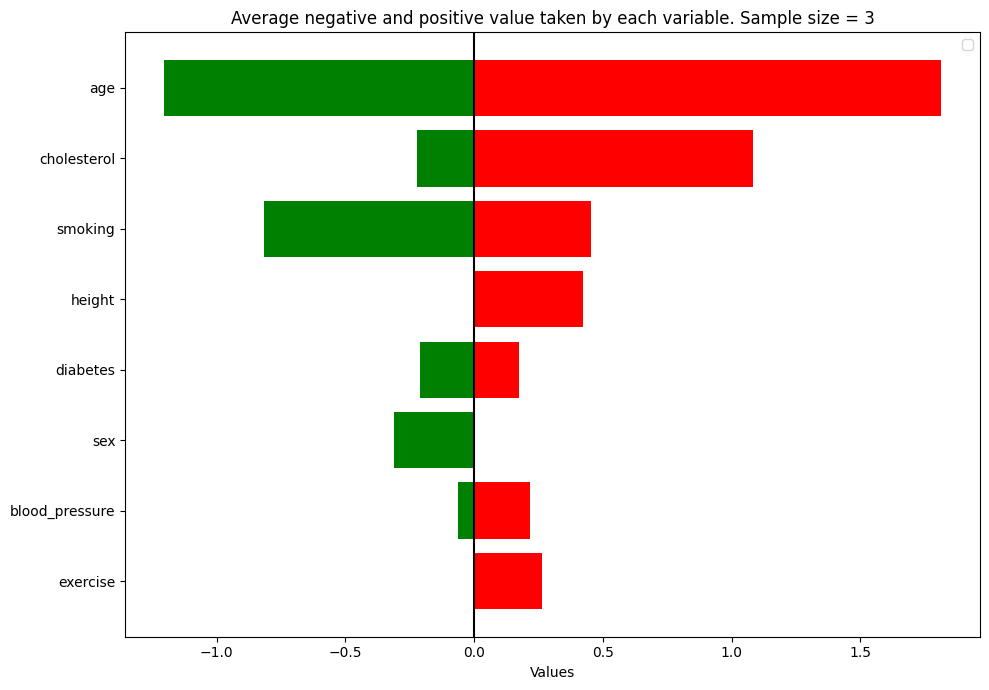

In [146]:
STS.averagesurvshap(3, 8)


100%|██████████| 800/800 [00:01<00:00, 412.56it/s]


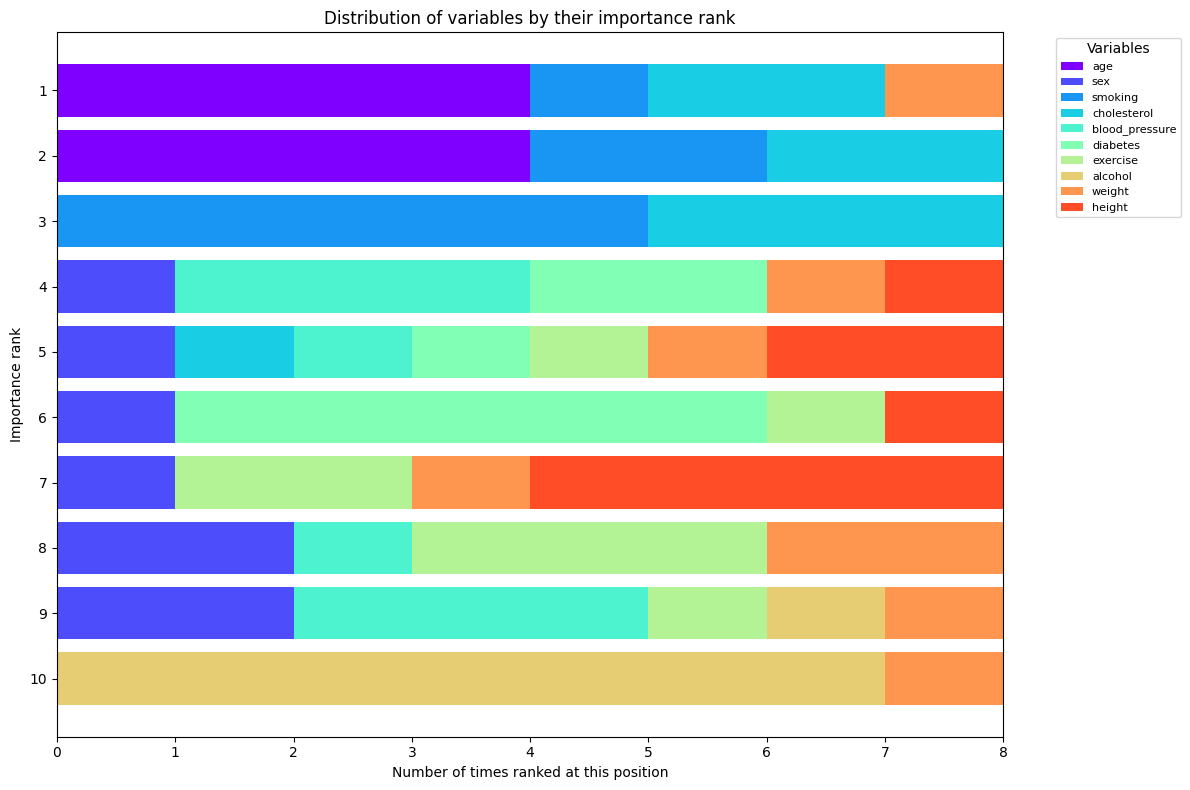

In [147]:
STS.rankvariables(8)

In [156]:
import time

In [157]:
def graph_var(n, X, y):
    y_kernel=[]
    y_tree=[]
    t=[]
    for i in tqdm(range(n)):
        X2 = X.astype(float)
        X2 = X2.iloc[:, :i+1]
        X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
        rsf = RandomSurvivalForest(random_state=42, max_depth=4, max_leaf_nodes=16).fit(X_train, y_train)

       # time KerneleSHAP

        explainer = SurvivalModelExplainer(model = rsf, data = X_train, y = y_train)
        observation_A = X_test.iloc[[0]]
        survshap_A = PredictSurvSHAP()

        start=time.time()
        survshap_A.fit(explainer = explainer, new_observation = observation_A) 
        y_kernel.append(time.time() - start)

        # time SurvTreeSHAP
        STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
        start=time.time()
        _=STS.computesurvshap(0)
        y_tree.append(time.time()- start)
        
        t.append(i)

    log_y_kernel=np.log(np.array(y_kernel))
    a, b = np.polyfit(t, log_y_kernel, 1)
    x_fit = np.linspace(min(t), max(t), 100)
    y_fit = np.exp(b) * (np.exp(a)**x_fit)
    plt.scatter(t, y_kernel, color='blue', label="Kernel")
    plt.plot(x_fit, y_fit, color='blue', label=f"y = {int(np.exp(b)*1000)/1000} *({int(np.exp(a)*1000)/1000}**d)")

    a, b = np.polyfit(t, y_tree, 1)
    x_fit = np.linspace(min(t), max(t), 100)
    y_fit = a * x_fit + b
    plt.scatter(t, y_tree, color='green', label="Tree")
    plt.plot(x_fit, y_fit, color='green', label=f"y = {int(a*1000)/1000}d + {int(b*1000)/1000}")

    plt.xlabel("Nombre de variables dans l'arbre")
    plt.ylabel("Temps d'exécution en secondes")
    plt.legend()
    plt.title("Temps d'exécution de SuvrSHAP(t) selon le nombre de variables dans la RSF")
    plt.grid()
    plt.show()
        

100%|██████████| 10/10 [07:44<00:00, 46.46s/it] 


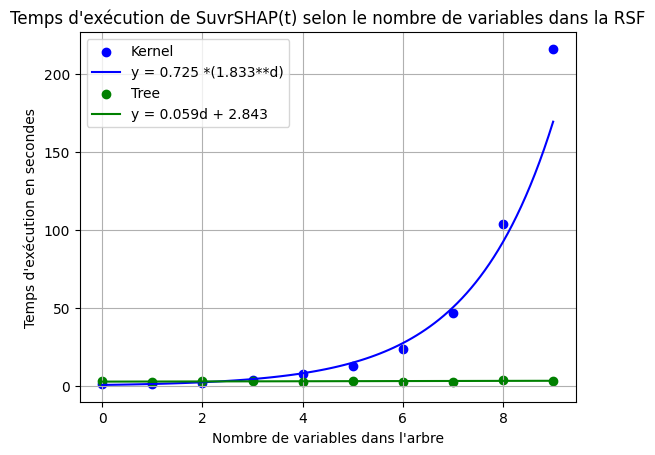

In [159]:
graph_var(10, X, y)

n=100, p=1 -> 0.0999s
n=100, p=2 -> 0.1296s
n=100, p=3 -> 0.1544s
n=100, p=4 -> 0.2879s
n=100, p=5 -> 0.5526s
n=100, p=6 -> 0.8989s
n=100, p=7 -> 1.8614s
n=100, p=8 -> 3.6126s
n=200, p=1 -> 0.1526s
n=200, p=2 -> 0.1889s
n=200, p=3 -> 0.2880s
n=200, p=4 -> 0.5194s
n=200, p=5 -> 0.7738s
n=200, p=6 -> 1.5141s
n=200, p=7 -> 3.1576s
n=200, p=8 -> 6.3291s
n=300, p=1 -> 0.3001s
n=300, p=2 -> 0.3229s
n=300, p=3 -> 0.5565s
n=300, p=4 -> 0.7635s
n=300, p=5 -> 1.3606s
n=300, p=6 -> 2.5707s
n=300, p=7 -> 5.4598s
n=300, p=8 -> 10.5862s
n=400, p=1 -> 0.3587s
n=400, p=2 -> 0.4692s
n=400, p=3 -> 0.6989s
n=400, p=4 -> 1.2823s
n=400, p=5 -> 2.1315s
n=400, p=6 -> 4.1423s
n=400, p=7 -> 6.2684s
n=400, p=8 -> 15.1436s
n=500, p=1 -> 0.4634s
n=500, p=2 -> 0.5795s
n=500, p=3 -> 0.8941s
n=500, p=4 -> 1.5621s
n=500, p=5 -> 2.7285s
n=500, p=6 -> 5.8277s
n=500, p=7 -> 10.7380s
n=500, p=8 -> 20.9728s
n=600, p=1 -> 0.6206s
n=600, p=2 -> 0.7483s
n=600, p=3 -> 1.3062s
n=600, p=4 -> 2.1066s
n=600, p=5 -> 3.7167s
n=600,

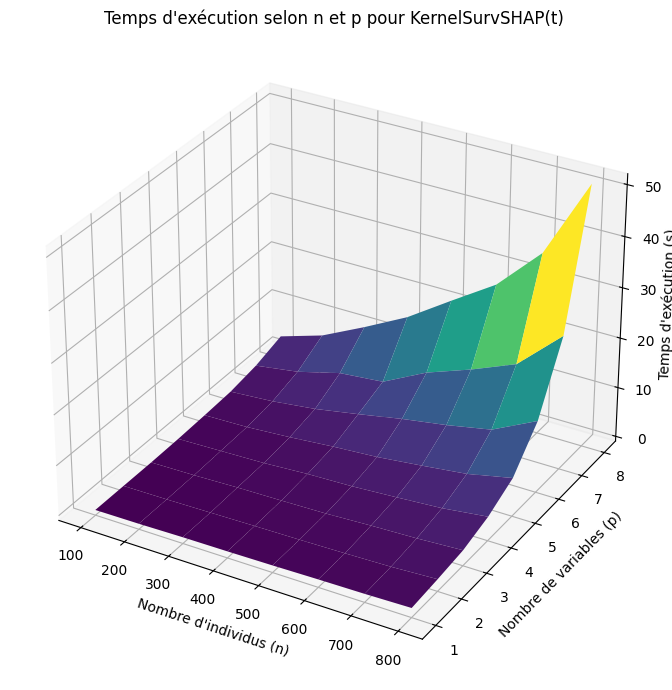

In [172]:
from mpl_toolkits.mplot3d import Axes3D

# Fonction de benchmark
def benchmark_algo(n_samples_list, n_features_list, X, y):
    results = []
    for n in n_samples_list:
        for p in n_features_list:
            # Simule données de survie
            X_b = X.iloc[:n, :p]
            y_b = y[:n]

            X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
            rsf = RandomSurvivalForest(random_state=42, max_depth=4, max_leaf_nodes=16).fit(X_train, y_train)

           # time KerneleSHAP

            explainer = SurvivalModelExplainer(model = rsf, data = X_train, y = y_train)
            observation_A = X_test.iloc[[0]]
            survshap_A = PredictSurvSHAP()

            start=time.time()
            survshap_A.fit(explainer = explainer, new_observation = observation_A) 
            elapsed = time.time() - start

            results.append((n, p, elapsed))
            print(f"n={n}, p={p} -> {elapsed:.4f}s")
    return pd.DataFrame(results, columns=["n_samples", "n_features", "time"])

# Définir plages de test
n_samples_list = [100, 200, 300, 400, 500, 600, 700, 800]
n_features_list = [1, 2, 3, 4, 5, 6, 7, 8]

# Lancer le benchmark
df = benchmark_algo(n_samples_list, n_features_list, X, y)

# Convertir en grille pour le plot
X_plot, Y_plot = np.meshgrid(n_samples_list, n_features_list)
Z_plot = np.array([
    df[(df.n_samples == x) & (df.n_features == y)].time.values[0]
    for x, y in zip(X_plot.ravel(), Y_plot.ravel())
]).reshape(X_plot.shape)

# Tracer en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_plot, Y_plot, Z_plot, cmap='viridis')
ax.set_xlabel('Nombre d\'individus (n)')
ax.set_ylabel('Nombre de variables (p)')
ax.set_zlabel('Temps d\'exécution (s)',labelpad = -0.2)
ax.set_title('Temps d\'exécution selon n et p pour KernelSurvSHAP(t)')

plt.tight_layout()
plt.show()

100%|██████████| 80/80 [00:00<00:00, 269.27it/s]


n=100, p=1 -> 0.3022s


100%|██████████| 80/80 [00:00<00:00, 243.30it/s]


n=100, p=2 -> 0.3318s


100%|██████████| 80/80 [00:00<00:00, 218.95it/s]


n=100, p=3 -> 0.3680s


100%|██████████| 80/80 [00:00<00:00, 246.55it/s]


n=100, p=4 -> 0.3334s


100%|██████████| 80/80 [00:00<00:00, 282.55it/s]


n=100, p=5 -> 0.2914s


100%|██████████| 80/80 [00:00<00:00, 234.44it/s]


n=100, p=6 -> 0.3445s


100%|██████████| 80/80 [00:00<00:00, 260.90it/s]


n=100, p=7 -> 0.3101s


100%|██████████| 80/80 [00:00<00:00, 262.95it/s]


n=100, p=8 -> 0.3084s


100%|██████████| 160/160 [00:00<00:00, 227.97it/s]


n=200, p=1 -> 0.7070s


100%|██████████| 160/160 [00:00<00:00, 228.44it/s]


n=200, p=2 -> 0.7057s


100%|██████████| 160/160 [00:00<00:00, 239.99it/s]


n=200, p=3 -> 0.6705s


100%|██████████| 160/160 [00:00<00:00, 221.84it/s]


n=200, p=4 -> 0.7241s


100%|██████████| 160/160 [00:00<00:00, 220.53it/s]


n=200, p=5 -> 0.7289s


100%|██████████| 160/160 [00:00<00:00, 231.19it/s]


n=200, p=6 -> 0.6944s


100%|██████████| 160/160 [00:00<00:00, 210.84it/s]


n=200, p=7 -> 0.7639s


100%|██████████| 160/160 [00:00<00:00, 221.57it/s]


n=200, p=8 -> 0.7252s


100%|██████████| 240/240 [00:01<00:00, 235.64it/s]


n=300, p=1 -> 1.0214s


100%|██████████| 240/240 [00:01<00:00, 222.13it/s]


n=300, p=2 -> 1.0849s


100%|██████████| 240/240 [00:01<00:00, 202.16it/s]


n=300, p=3 -> 1.1957s


100%|██████████| 240/240 [00:01<00:00, 212.83it/s]


n=300, p=4 -> 1.1385s


100%|██████████| 240/240 [00:01<00:00, 219.09it/s]


n=300, p=5 -> 1.0976s


100%|██████████| 240/240 [00:01<00:00, 212.86it/s]


n=300, p=6 -> 1.1305s


100%|██████████| 240/240 [00:01<00:00, 215.42it/s]


n=300, p=7 -> 1.1169s


100%|██████████| 240/240 [00:01<00:00, 215.46it/s]


n=300, p=8 -> 1.1175s


100%|██████████| 320/320 [00:01<00:00, 231.17it/s]


n=400, p=1 -> 1.3896s


100%|██████████| 320/320 [00:01<00:00, 221.62it/s]


n=400, p=2 -> 1.4465s


100%|██████████| 320/320 [00:01<00:00, 207.93it/s]


n=400, p=3 -> 1.5424s


100%|██████████| 320/320 [00:01<00:00, 190.41it/s]


n=400, p=4 -> 1.6897s


100%|██████████| 320/320 [00:01<00:00, 193.61it/s]


n=400, p=5 -> 1.6673s


100%|██████████| 320/320 [00:01<00:00, 220.51it/s]


n=400, p=6 -> 1.4564s


100%|██████████| 320/320 [00:01<00:00, 197.70it/s]


n=400, p=7 -> 1.6233s


100%|██████████| 320/320 [00:01<00:00, 196.09it/s]


n=400, p=8 -> 1.6358s


100%|██████████| 400/400 [00:01<00:00, 215.59it/s]


n=500, p=1 -> 1.8603s


100%|██████████| 400/400 [00:01<00:00, 202.40it/s]


n=500, p=2 -> 1.9810s


100%|██████████| 400/400 [00:02<00:00, 199.79it/s]


n=500, p=3 -> 2.0056s


100%|██████████| 400/400 [00:01<00:00, 209.10it/s]


n=500, p=4 -> 1.9159s


100%|██████████| 400/400 [00:01<00:00, 208.92it/s]


n=500, p=5 -> 1.9207s


100%|██████████| 400/400 [00:02<00:00, 195.68it/s]


n=500, p=6 -> 2.0501s


100%|██████████| 400/400 [00:02<00:00, 192.47it/s]


n=500, p=7 -> 2.0815s


100%|██████████| 400/400 [00:02<00:00, 198.82it/s]


n=500, p=8 -> 2.0159s


100%|██████████| 480/480 [00:02<00:00, 229.17it/s]


n=600, p=1 -> 2.1008s


100%|██████████| 480/480 [00:02<00:00, 200.05it/s]


n=600, p=2 -> 2.4054s


100%|██████████| 480/480 [00:02<00:00, 205.95it/s]


n=600, p=3 -> 2.3350s


100%|██████████| 480/480 [00:02<00:00, 201.80it/s]


n=600, p=4 -> 2.3823s


100%|██████████| 480/480 [00:02<00:00, 204.23it/s]


n=600, p=5 -> 2.3545s


100%|██████████| 480/480 [00:02<00:00, 204.59it/s]


n=600, p=6 -> 2.3524s


100%|██████████| 480/480 [00:02<00:00, 205.48it/s]


n=600, p=7 -> 2.3392s


100%|██████████| 480/480 [00:02<00:00, 203.71it/s]


n=600, p=8 -> 2.3602s


100%|██████████| 560/560 [00:02<00:00, 226.39it/s]


n=700, p=1 -> 2.4785s


100%|██████████| 560/560 [00:02<00:00, 215.23it/s]


n=700, p=2 -> 2.6073s


100%|██████████| 560/560 [00:02<00:00, 198.07it/s]


n=700, p=3 -> 2.8313s


100%|██████████| 560/560 [00:02<00:00, 204.60it/s]


n=700, p=4 -> 2.7415s


100%|██████████| 560/560 [00:02<00:00, 203.69it/s]


n=700, p=5 -> 2.7533s


100%|██████████| 560/560 [00:02<00:00, 200.99it/s]


n=700, p=6 -> 2.7906s


100%|██████████| 560/560 [00:02<00:00, 208.71it/s]


n=700, p=7 -> 2.6889s


100%|██████████| 560/560 [00:02<00:00, 194.34it/s]


n=700, p=8 -> 2.8853s


100%|██████████| 640/640 [00:02<00:00, 236.86it/s]


n=800, p=1 -> 2.7062s


100%|██████████| 640/640 [00:02<00:00, 223.30it/s]


n=800, p=2 -> 2.8711s


100%|██████████| 640/640 [00:03<00:00, 204.25it/s]


n=800, p=3 -> 3.1434s


100%|██████████| 640/640 [00:03<00:00, 209.49it/s]


n=800, p=4 -> 3.0635s


100%|██████████| 640/640 [00:03<00:00, 209.46it/s]


n=800, p=5 -> 3.0610s


100%|██████████| 640/640 [00:03<00:00, 200.40it/s]


n=800, p=6 -> 3.1987s


100%|██████████| 640/640 [00:03<00:00, 196.78it/s]


n=800, p=7 -> 3.2612s


100%|██████████| 640/640 [00:03<00:00, 192.26it/s]


n=800, p=8 -> 3.3335s


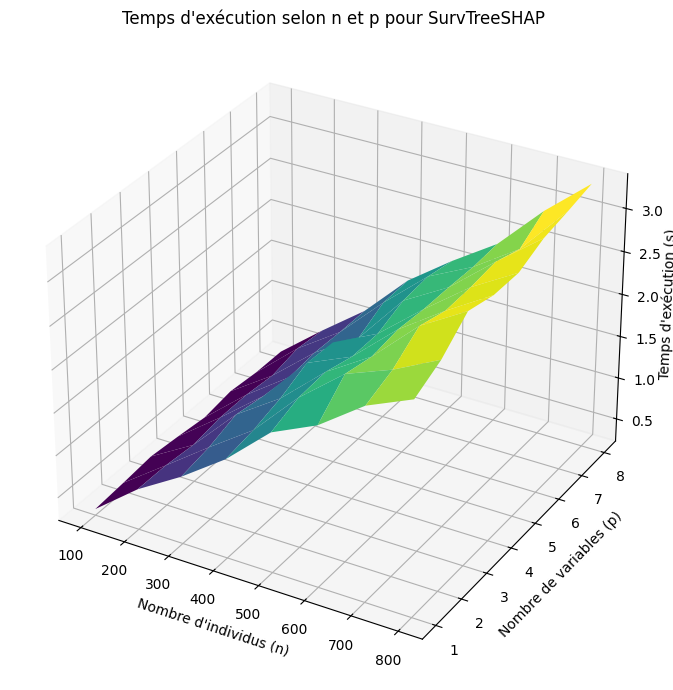

In [173]:
def benchmark_algo(n_samples_list, n_features_list, X, y):
    results = []
    for n in n_samples_list:
        for p in n_features_list:
            # Simule données de survie
            X_b = X.iloc[:n, :p]
            y_b = y[:n]

            X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
            rsf = RandomSurvivalForest(random_state=42, max_depth=4, max_leaf_nodes=16).fit(X_train, y_train)

           # time SurvTreeSHAP

            explainer = SurvivalModelExplainer(model = rsf, data = X_train, y = y_train)

            STS=fstp.SurvTreeSHAPexplainer(rsf, X_test)
            start=time.time()
            _=STS.computesurvshap(0)
            elapsed = time.time()- start

            results.append((n, p, elapsed))
            print(f"n={n}, p={p} -> {elapsed:.4f}s")
    return pd.DataFrame(results, columns=["n_samples", "n_features", "time"])

# Définir plages de test
n_samples_list = [100, 200, 300, 400, 500, 600, 700, 800]
n_features_list = [1, 2, 3, 4, 5, 6, 7, 8]

# Lancer le benchmark
df = benchmark_algo(n_samples_list, n_features_list, X, y)

# Convertir en grille pour le plot
X_plot, Y_plot = np.meshgrid(n_samples_list, n_features_list)
Z_plot = np.array([
    df[(df.n_samples == x) & (df.n_features == y)].time.values[0]
    for x, y in zip(X_plot.ravel(), Y_plot.ravel())
]).reshape(X_plot.shape)

# Tracer en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_plot, Y_plot, Z_plot, cmap='viridis')

ax.set_xlabel('Nombre d\'individus (n)')
ax.set_ylabel('Nombre de variables (p)')
ax.set_zlabel('Temps d\'exécution (s)', labelpad = -0.2)
ax.set_title('Temps d\'exécution selon n et p pour SurvTreeSHAP')

plt.tight_layout()
plt.show()